In [1]:
from util_functions import *
%load_ext autoreload
%autoreload 2
device = 'cuda:6'



def train_step(data_loader, model, opt, bce_loss, epoch, verbose=True):
    mean_acc = 0
    mean_loss = 0
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    _batch_size = 0
    with tqdm(data_loader, disable=not verbose) as pbar:
        for batch_idx, batch in enumerate(pbar):
            eeg = batch['eeg']
            v0 = batch['v0']
            v1 = batch['v1']
            match_label = batch['match_label']
            _batch_size = max(_batch_size, eeg.shape[0])
            eeg = eeg.to(device)
            v0 = v0.to(device)
            v1 = v1.to(device)
            match_label = match_label.to(device)
            # update match model network
            model.zero_grad()
            match_pred = model(eeg, v0, v1)
            match_loss = bce_loss(match_pred, match_label)
            match_loss.backward()
            match_pred_acc = accuracy(match_pred, match_label)
            opt.step()
            # logging
            mean_acc = (match_pred_acc * eeg.shape[0] / _batch_size + mean_acc * batch_idx) / (batch_idx + 1)
            mean_loss = (match_loss.item() * eeg.shape[0] / _batch_size + mean_loss * batch_idx) / (batch_idx + 1)
            if verbose:
                pbar.set_postfix(train='train', epoch=epoch, batch_idx=batch_idx, match_loss=mean_loss,
                                 mean_acc=mean_acc)
    return mean_acc, mean_loss


def eval_step(data_loader, model, bce_loss, epoch=None, verbose=True):
    mean_acc = 0
    mean_loss = 0
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    _batch_size = 0
    with tqdm(data_loader, disable=not verbose) as pbar:
        for batch_idx, batch in enumerate(pbar):
            eeg = batch['eeg']
            v0 = batch['v0']
            v1 = batch['v1']
            match_label = batch['match_label']
            _batch_size = max(_batch_size, eeg.shape[0])
            eeg = eeg.to(device)
            v0 = v0.to(device)
            v1 = v1.to(device)
            match_label = match_label.to(device)
            # update matchmodel network
            match_pred = model(eeg, v0, v1)
            match_loss = bce_loss(match_pred, match_label)
            match_pred_acc = accuracy(match_pred, match_label)
            # logging
            mean_acc = (match_pred_acc * eeg.shape[0] / _batch_size + mean_acc * batch_idx) / (batch_idx + 1)
            mean_loss = (match_loss.item() * eeg.shape[0] / _batch_size + mean_loss * batch_idx) / (batch_idx + 1)
            if verbose:
                pbar.set_postfix(eval='eval', epoch=epoch, batch_idx=batch_idx, match_loss=mean_loss, mean_acc=mean_acc)
    return mean_acc, mean_loss


def test_model(match_model, cp_path, test_loader, bce_loss, verbose):
    checkpoint = torch.load(cp_path)
    match_model.load_state_dict(checkpoint)
    match_model.eval()
    match_model.to(device)
    test_mean_acc, test_mean_loss = eval_step(test_loader, match_model, bce_loss, verbose)
    return test_mean_acc, test_mean_loss


def train_test_model(match_model, train_loader, val_loader, test_loader, exp_name, dir_name='video_match',
                     device=device, if_plot=False,
                     verbose=True, epoch_verbose=True):
    def plot(train_acc_list, eval_acc_list, train_loss_list, eval_loss_list):
        plt.figure()
        plt.plot(train_acc_list)
        plt.plot(eval_acc_list)
        plt.legend(['train', 'dev'])
        plt.title('acc')
        plt.show()
        plt.figure()
        plt.plot(train_loss_list)
        plt.plot(eval_loss_list)
        plt.legend(['train', 'dev'])
        plt.title('loss')
        plt.show()

    cp_path = f'{dir_name}/{exp_name}/model_best.pth'
    json_path = f'{dir_name}/{exp_name}/info.json'
    match_model.to(device)
    optM = optim.Adam(match_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optM, mode='max', factor=0.1, patience=5, verbose=False)
    early_stopping = EarlyStopping(patience=10, verbose=False)
    num_epochs = 100
    bce_loss = nn.BCELoss()
    train_loss_list = []
    train_acc_list = []
    eval_loss_list = []
    eval_acc_list = []
    learning_rates = []
    disable = not epoch_verbose
    with tqdm(range(num_epochs), disable=disable) as pbar:
        for epoch in pbar:
            train_acc, train_loss = train_step(train_loader, match_model, optM, bce_loss, epoch, verbose=verbose)
            eval_acc, eval_loss = eval_step(val_loader, match_model, bce_loss, epoch, verbose=verbose)
            scheduler.step(eval_acc)
            train_acc_list.append(train_acc)
            eval_acc_list.append(eval_acc)
            train_loss_list.append(train_loss)
            eval_loss_list.append(eval_loss)
            if if_plot:
                plot(train_acc_list, eval_acc_list, train_loss_list, eval_loss_list)
            early_stopping(-eval_acc, match_model, mkdir(cp_path))
            learning_rates.append(optM.param_groups[0]['lr'])
            pbar.set_postfix(epoch=epoch,
                             train_acc=train_acc,
                             train_loss=train_loss,
                             eval_acc=eval_acc,
                             eval_loss=eval_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break
    test_acc, test_loss = test_model(match_model, cp_path, test_loader, bce_loss, verbose=epoch_verbose)
    save_info = {
        'epoch': epoch + 1,
        'train_loss_list': train_loss_list,
        'train_acc_list': train_acc_list,

        'eval_loss_list': eval_loss_list,
        'eval_acc_list': eval_acc_list,

        'test_loss': test_loss,
        'test_acc': test_acc,

        # 'train_ids':train_loader.dataset.person_ids,
        # 'val_ids':val_loader.dataset.person_ids,
        # 'test_ids':test_loader.dataset.person_ids,

        'trainable_param': count_trainable_param(match_model),
        'learning_rates': learning_rates
    }
    with open(json_path, "w") as f:
        json.dump(save_info, f)
    return save_info

In [2]:
# two files to load
eeg_signal89 = torch.load('eeg_signal.pth')
moviefeat_dict = torch.load('movie0.pth')
# get EEG_data_info.pkl in the folder
keys_list = np.array(list(eeg_signal89.keys()))

In [3]:

def load_exp_model(exp_name):
    model_name = exp_name.split('_')[-2]
    # print(model_name)
    match_model = init_models(model_name)
    cp_path = f'{dir_name}/{exp_name}/model_best.pth'
    # print(cp_path)
    checkpoint = torch.load(cp_path)
    match_model.load_state_dict(checkpoint)
    return match_model

In [5]:
dir_name='exp_7_20n'
all_save_info_dict={}
table=[]
# model_names = [
#         'DilationModel', 'DilationVideoGRUModel', 'DilationVideoLSTMModel',
#                    'DilationGRUEEGModel',
#         'DilationRevGRUEEGModel',
#         'DilationRevGRUVideoGRUModel',
#                    'CNNTransformer1HeadVideoGRULowDimModel',
#                    'CNNTransformer1HeadVideoGRUModel', 'OneWayDilationVideoGRUModel']
model_names = [
        'DilationModel', 'DilationVideoGRUModel', 'DilationVideoLSTMModel',
                   'DilationGRUEEGModel',
        # 'DilationRevGRUEEGModel',
        # 'DilationRevGRUVideoGRUModel',
                   'CNNTransformer1HeadVideoGRULowDimModel',
                   'CNNTransformer1HeadVideoGRUModel', 'OneWayDilationVideoGRUModel']
# model_names = ['OneWayDilationVideoGRUModel']
trainable_params=[]
for run_idx in range(5):
    with open(f'{dir_name}/run_idx{run_idx}_all_save_info_dict.json', 'r') as f:
        run_info = json.load(f)
        # print(run_info)
    all_save_info_dict[run_idx]=run_info
    row=[]
    for i, name in enumerate(model_names):
        exp_name = f'run_idx{run_idx}_{name}_exp1'
        trainable_param=run_info[f'run_idx{run_idx}_{name}_exp1']['trainable_param']
        model=load_exp_model(exp_name)
        trainable_param=count_trainable_param(model)
        if run_idx==0:
            trainable_params.append(trainable_param)
        # print(trainable_param)
        row.append(run_info[exp_name]['test_acc'])
        # print(run_info[exp_name]['test_acc'])
    table.append(row)
table=np.array(table)*100
# print(table.shape)
# print(table.mean(0))
# print(table.std(0))

In [272]:
# trainable_param
run_idx=0
name=model_names[3]
all_save_info_dict[run_idx][f'run_idx{run_idx}_{name}_exp1']['trainable_param']

0.0

In [119]:
table=np.concatenate([table,np.array(test_accs)[:,None]],axis=-1)

7 7


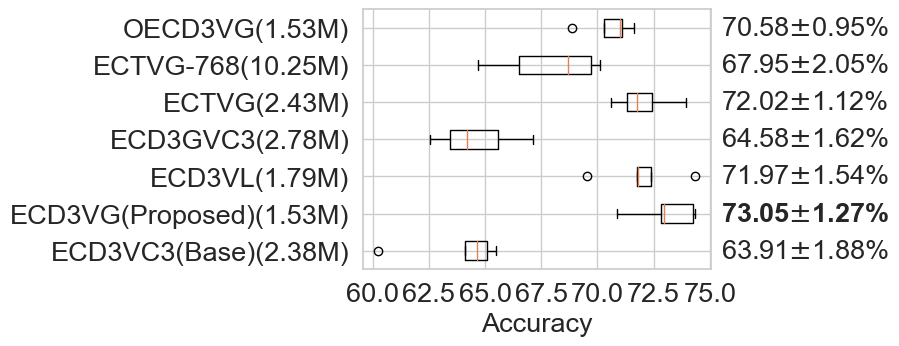

In [21]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
# 设置字体和字号
all_save_info_dict[0]
# 绘制图表
# fig, ax = plt.subplots()
import matplotlib.pyplot as plt

fontsize=13
column_width=3.25
columns=1
hw_ratio=0.5
scale=1.5
font_scale=1.5
fontsize=fontsize*font_scale
w=3*columns*scale
h=w*columns*hw_ratio*scale

model_nicknames = [
        'ECD3VC3(Base)', 'ECD3VG(Proposed)', 'ECD3VL',
        'ECD3GVC3',
    # 'ECD3RGVC3','ECD3RGVG',
        'ECTVG','ECTVG-768', 'OECD3VG']
print(len(model_nicknames),len(trainable_params))
model_nicknames=[f'{model_nicknames[i]}({np.round(trainable_params[i],2)}M)' for i in range(len(model_nicknames))]
fig, ax = plt.subplots(figsize=(w,h))  
sns.set(style="whitegrid")
ax.boxplot(table,vert=False)
# ax.set_title('Model Accuracy', fontsize=fontsize)
# ax.set_ylabel('Model Name', fontsize=fontsize)
ax.set_xlabel('Accuracy', fontsize=fontsize)
for i in range(table.shape[1]):
    if i in [1]:
        fontweight='bold'
    else:
        fontweight=None
        
    ax.text(75.5,i+0.8,f'{np.round(table.mean(0)[i],2)}$\pm${np.round(table.std(0)[i],2)}%',fontweight=fontweight, fontsize=fontsize)
# ax.set_yticks(fontsize=20)
# ax.set_yticklabels(fontsize=20)
# ax.yaxis.label.set_size(20)
# ax.yaxis.set_ticklabels(20)
ax.set_yticklabels(model_nicknames, fontsize=fontsize)
# 显示图表
xticks = ax.get_xticklabels()
# 把x轴刻度标签字体大小改为14号
for xtick in xticks:
    xtick.set_fontsize(fontsize)
    # xtick.set_fontweight('bold')
plt.savefig('paper/models_performance.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [240]:

def channel_gradients_for_loader(data_loader, model, bce_loss=nn.BCELoss(),  verbose=True):
    mean_gradient = 0
    model.train()
    for p in model.parameters():
        p.requires_grad = True
    _batch_size = 0
    with tqdm(data_loader, disable=not verbose) as pbar:
        for batch_idx, batch in enumerate(pbar):
            eeg = batch['eeg']
            v0 = batch['v0']
            v1 = batch['v1']
            match_label = batch['match_label']
            
            _batch_size = max(_batch_size, eeg.shape[0])
            eeg = eeg.to(device)
            v0 = v0.to(device)
            v1 = v1.to(device)
            match_label = match_label.to(device)
            # update match model network
            model.zero_grad()
            
            eeg = Variable(eeg, requires_grad=True)
            batch_gradient_mean=0
            for itid in range(eeg.shape[0]):
                match_pred = model(eeg[itid:itid+1], v0[itid:itid+1], v1[itid:itid+1])
                with torch.no_grad():
                    match_pred.backward()
                    gradient = eeg.grad.data.abs().mean(dim=[0,-1]).squeeze()
                    batch_gradient_mean=batch_gradient_mean+gradient
            batch_gradient_mean=batch_gradient_mean/eeg.shape[0]
            # logging
            mean_gradient = (batch_gradient_mean * eeg.shape[0] / _batch_size + batch_gradient_mean * batch_idx) / (batch_idx + 1)
    return mean_gradient

In [241]:
seg_id = 0
gradients=[]
for run_idx in range(5):
    test_ids=all_save_info_dict[run_idx]['test_ids']
    match_model = load_exp_model(f'run_idx{run_idx}_DilationVideoGRUModel_exp1').to('cuda:6')
    test_data1 = get_data_different_sep_seconds(CustomTraditionDataset, moviefeat_dict[seg_id], eeg_signal89, test_ids,
                                                seg_id=seg_id, window_seconds=window_seconds,
                                                shift_seconds=shift_seconds, sep_seconds=[1, -7])
    test_eeg_loader1 = DataLoader(test_eeg_data1, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=col_fn)
    gradient=channel_gradients_for_loader(test_eeg_loader1, match_model)
    gradients.append(gradient)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]


In [127]:
def scale01(a):
    a_max=np.max(a)
    a_min=np.min(a)
    a=(a-a_min)/(a_max-a_min)
    return a

In [242]:
gradients_table=np.array(torch.stack(gradients,0).detach().cpu())
gradients_table=scale01(gradients_table)
gradients_table=np.swapaxes(gradients_table,0,1)

In [243]:
import matplotlib.collections as collections

with open('EEG_data_info.pkl', 'rb') as f:
    info = pickle.load(f)
# 要排除的通道名称列表
exclude_channels = ['M1', 'M2']

# 生成新的 names 列表，不包含要排除的通道名称
wanted_index = [i for i,name in enumerate(info.ch_names[:64]) if name not in exclude_channels]
print(len(wanted_index))
keys = list(info.get_montage().get_positions()['ch_pos'].keys())
print(len(keys))
keys = [keys[idx] for idx in wanted_index]
pos = np.stack(info.get_montage().get_positions()['ch_pos'].values(), 0)[wanted_index]
pos[:, :2] = -pos[:, :2]
max_z=np.max(pos[:, 2])
z_scale=max_z/pos[:, 2]
pos=z_scale[:,None]*pos*0.5
sensorPosition = dict(zip(keys, pos)) 
myMontage = mne.channels.make_dig_montage(ch_pos=sensorPosition)

info = mne.create_info(
    ch_names=keys,
    ch_types=['eeg'] * len(wanted_index), 
    sfreq=1000) 
info.set_montage(myMontage)

62
64


/home/yyang/anaconda3/envs/torch10_py381/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_2474144/790457570.py:26: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(myMontage)


<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 1000.0 Hz
>

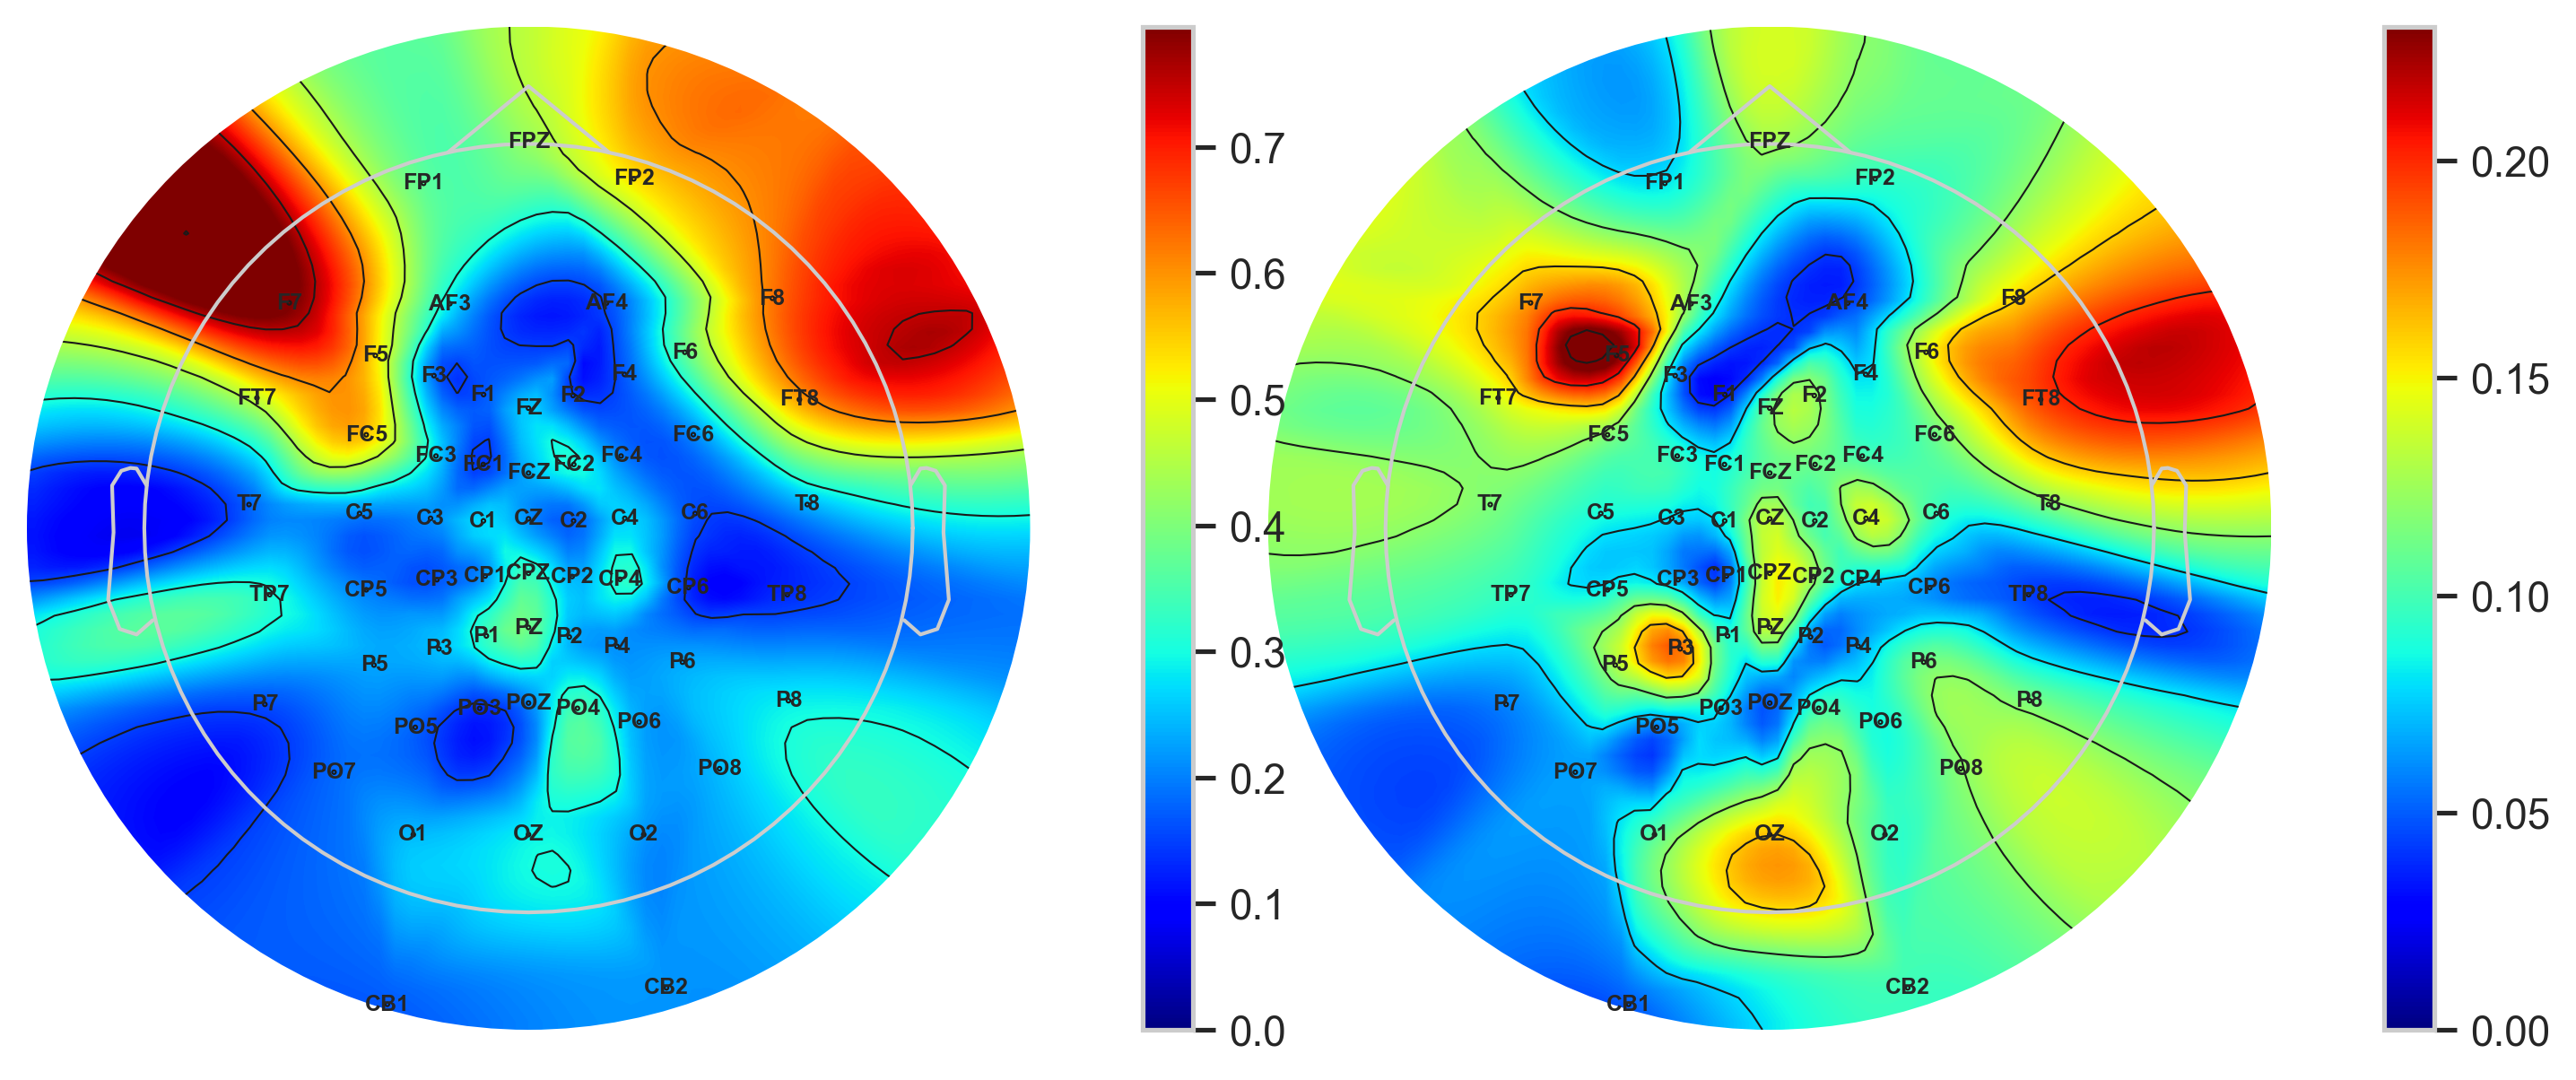

In [311]:

figure_scale=1.67
font_size=6
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]},figsize=(8*figure_scale, 2.5*figure_scale), dpi=300)
# fig, ax = plt.subplots(1,2,figsize=(8*figure_scale, 2.5*figure_scale), dpi=300)
im, cn = mne.viz.plot_topomap(gradients_table.mean(-1)[wanted_index].tolist(),
                              info, axes=ax[0],
                              names=keys,
                              # vlim=(-2, 2)
                              show=False, cmap='jet'
                              )
plt.colorbar(im)
for child in ax[0].get_children():
    if isinstance(child, mpl.text.Text):
        child.set_fontsize(font_size)
        child.set_fontweight(weight='bold')
# ax[0].set_title('mean',fontsize=25)
im, cn = mne.viz.plot_topomap(gradients_table.std(-1)[wanted_index].tolist(),
                              info, axes=ax[1],
                              names=keys,
                              # vlim=(-2, 2)
                              show=False, cmap='jet'
                              )
for child in ax[1].get_children():
    if isinstance(child, mpl.text.Text):
        child.set_fontsize(font_size)
        child.set_fontweight(weight='bold')
# ax[1].set_title('std',fontsize=25)
plt.colorbar(im)

plt.tight_layout()
plt.subplots_adjust(wspace=-0.45)
# plt.savefig('paper/avg_heat_map_over_eeg_channels.eps', bbox_inches='tight')
# plt.savefig('paper/avg_heat_map_over_eeg_channels.png', bbox_inches='tight')
plt.savefig('paper/avg_heat_map_over_eeg_channels.pdf', bbox_inches='tight')
plt.show()

In [132]:
# balance and imbalance dataset experiment
# imbalance dataset, only one mismatch after match
run_idx=0
dir_name='exp_7_20n'
with open(f'{dir_name}/run_idx{run_idx}_all_save_info_dict.json', "r") as f:
    save_info_dict=json.load(f)
train_ids=save_info_dict['train_ids']
val_ids=save_info_dict['val_ids']
test_ids=save_info_dict['test_ids']
train_data4 = get_data_different_sep_seconds(CustomDataset, moviefeat_dict[seg_id], eeg_signal89, train_ids,
                                             seg_id=seg_id, window_seconds=window_seconds,
                                             shift_seconds=shift_seconds, sep_seconds=[1, ])
val_data4 = get_data_different_sep_seconds(CustomDataset, moviefeat_dict[seg_id], eeg_signal89, val_ids,
                                           seg_id=seg_id, window_seconds=window_seconds,
                                           shift_seconds=shift_seconds, sep_seconds=[1, ])
test_data4 = get_data_different_sep_seconds(CustomDataset, moviefeat_dict[seg_id], eeg_signal89, test_ids,
                                            seg_id=seg_id, window_seconds=window_seconds,
                                            shift_seconds=shift_seconds, sep_seconds=[1, ])

train_loader4 = DataLoader(train_data4, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                           collate_fn=col_fn)
val_loader4 = DataLoader(val_data4, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=col_fn)
test_loader4 = DataLoader(test_data4, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          collate_fn=col_fn)

exp_name = 'DilationVideoGRUModel_exp4'
match_model = init_models('DilationVideoGRUModel')
train_test_model(match_model, train_loader=train_loader4, val_loader=val_loader4,
                                            test_loader=test_loader4, exp_name=exp_name,dir_name=dir_name, verbose=False)

 21%|███████████████████████                                                                                       | 21/100 [07:06<26:46, 20.33s/it, epoch=21, eval_acc=0.882, eval_loss=0.221, train_acc=0.997, train_loss=0.00559]


Early stopping


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.94it/s, batch_idx=19, epoch=1, eval=eval, match_loss=0.153, mean_acc=0.927]


{'epoch': 22,
 'train_loss_list': [0.6859215196949264,
  0.651864098353082,
  0.5990524085825437,
  0.5449563297634463,
  0.45761140327811345,
  0.37518751158774516,
  0.303091236795235,
  0.2326042700833195,
  0.1723871317035072,
  0.13030209653605773,
  0.0972112256528057,
  0.07263437347177235,
  0.054203289779053025,
  0.03733269372286772,
  0.024246519669684684,
  0.01729191846632054,
  0.019275874473562795,
  0.014404924604954033,
  0.008578128414726912,
  0.006792206804874858,
  0.00609088828239019,
  0.0055884816294116575],
 'train_acc_list': [0.5279323630136986,
  0.6117294520547948,
  0.6727846746575342,
  0.7415988869863014,
  0.8258775684931506,
  0.8806720890410958,
  0.9054473458904112,
  0.9355736301369864,
  0.9571382705479452,
  0.9711044520547946,
  0.9812178938356164,
  0.9865689212328768,
  0.9912778253424658,
  0.9941673801369864,
  0.9960402397260274,
  0.9967358732876712,
  0.9953446061643836,
  0.9962542808219178,
  0.996896404109589,
  0.996896404109589,
  0.99

In [ ]:
match_model1 = load_exp_model('run_idx0_DilationVideoGRUModel_exp1').to('cuda:6')
match_model4 = load_exp_model('DilationVideoGRUModel_exp4').to('cuda:6')
test_sep_seconds_list = np.arange(-23, 20)
acc_list1 = []
loss_list1 = []
acc_list4 = []
loss_list4 = []
seg_id = 0
for test_sep_seconds in test_sep_seconds_list:
    evaluation_loader1 = DataLoader(
        CustomDataset(moviefeat_dict[seg_id],
                      eeg_signal89,
                      test_ids, seg_id=seg_id,
                      window_seconds=3, sep_seconds=test_sep_seconds, ), batch_size=batch_size, shuffle=True,
        num_workers=0, collate_fn=col_fn)
    evaluation_acc1, evaluation_loss1 = eval_step(evaluation_loader1, match_model1, nn.BCELoss(),verbose=False)
    evaluation_acc4, evaluation_loss4 = eval_step(evaluation_loader1, match_model4, nn.BCELoss(),verbose=False)
    acc_list1.append(evaluation_acc1)
    acc_list4.append(evaluation_acc4)

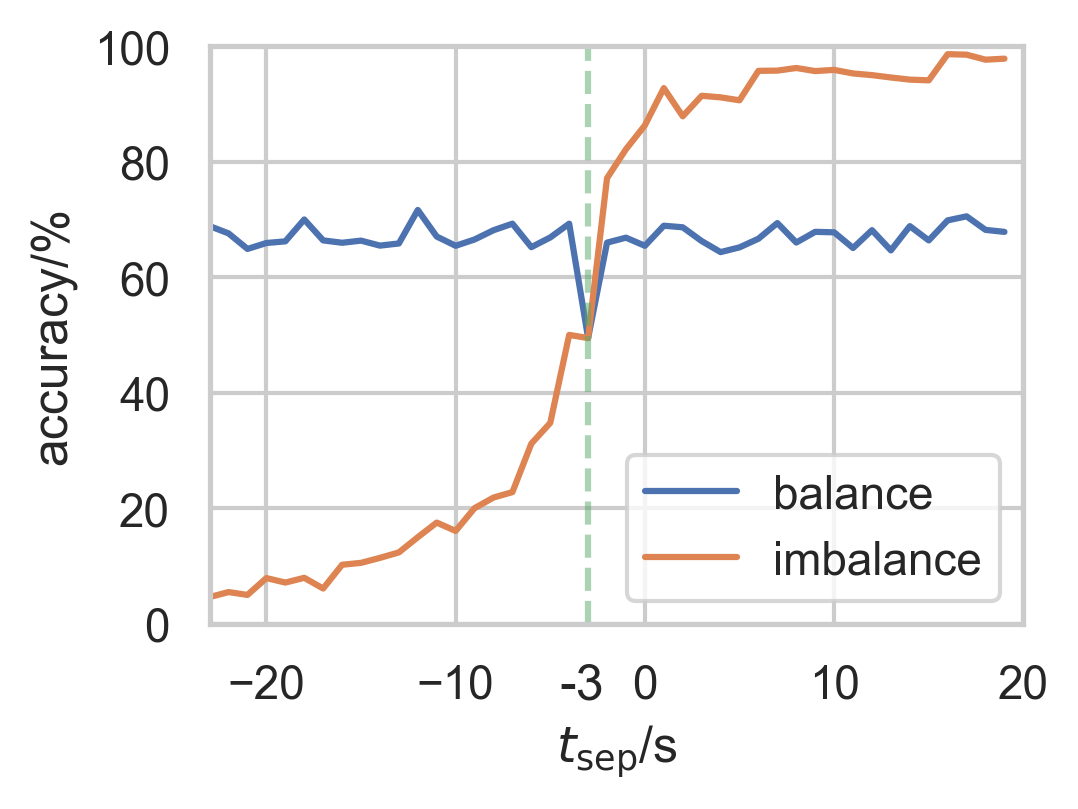

In [339]:
##### acc_list1=np.array(acc_list1)/100
# acc_list4=np.array(acc_list4)/100
plt.figure(figsize=(3.5, 2.5), dpi=300)
plt.plot(test_sep_seconds_list, acc_list1)
plt.plot(test_sep_seconds_list, acc_list4)
plt.legend(['balance', 'imbalance'])
plt.xlabel('$t_{\mathrm{sep}}$/s')
plt.ylabel('accuracy/%')
plt.vlines(-3, 0, 100, 'g',linestyles='--',alpha=0.5)
plt.ylim([0,100])
plt.xlim([-23,20])
# plt.hlines(50, min(test_sep_seconds_list), max(test_sep_seconds_list), 'r',alpha=0.5)
# plt.text(-20, 51, 'y=50%')
plt.text(-4.5, -13, '-3')
# plt.savefig(mkdir('paper/wrong_accuracy_and_sep_seconds.png'))
plt.savefig(mkdir('paper/wrong_accuracy_and_sep_seconds.pdf'), bbox_inches='tight')
plt.show()

In [22]:
# experiments for some fun
run_idx=0
dir_name='exp_7_20n'
with open(f'{dir_name}/run_idx{run_idx}_all_save_info_dict.json', "r") as f:
    save_info_dict=json.load(f)
train_ids=save_info_dict['train_ids']
val_ids=save_info_dict['val_ids']
test_ids=save_info_dict['test_ids']
match_model = load_exp_model(f'run_idx{run_idx}_OneWayDilationVideoGRUModel_exp1').to('cuda:6')

seg_id = 0

train_eeg_data1 = CustomDataset(moviefeat_dict[seg_id],
                                eeg_signal89,
                                train_ids,
                                seg_id=seg_id,
                                window_seconds=3,
                                shift_seconds=3,
                                sep_seconds=-3)
train_eeg_loader1 = DataLoader(train_eeg_data1, batch_size=batch_size, shuffle=False, num_workers=num_workers)
train_eeg_feature_list, train_video_feature_list, train_img_idx_list = get_eeg_features(train_eeg_loader1,
                                                                                        match_model, device)
print(train_eeg_feature_list.shape, train_video_feature_list.shape, train_img_idx_list.shape)
test_eeg_data1 = CustomDataset(moviefeat_dict[seg_id],
                               eeg_signal89,
                               test_ids,
                               seg_id=seg_id,
                               window_seconds=3,
                               shift_seconds=3,
                               sep_seconds=-3)
test_eeg_loader1 = DataLoader(test_eeg_data1, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_eeg_feature_list, test_video_feature_list, test_img_idx_list = get_eeg_features(test_eeg_loader1, match_model,
                                                                                     device)



match_model.to('cpu')
test_feature_cos = F.cosine_similarity(test_eeg_feature_list, test_video_feature_list, dim=-1)
test_matchable = F.sigmoid(match_model.fc_layer(test_feature_cos))
train_feature_cos = F.cosine_similarity(train_eeg_feature_list, train_video_feature_list, dim=-1)
train_matchable = F.sigmoid(match_model.fc_layer(train_feature_cos))
train_matchable=train_matchable.detach().cpu()
train_feature_cos=train_feature_cos.detach().cpu()
test_matchable=test_matchable.detach().cpu()
test_feature_cos=test_feature_cos.detach().cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.70it/s]


torch.Size([3195, 256, 75]) torch.Size([3195, 256, 75]) torch.Size([3195])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.75it/s]
/home/yyang/anaconda3/envs/torch10_py381/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train acc:96.84%
 test acc:68.78%


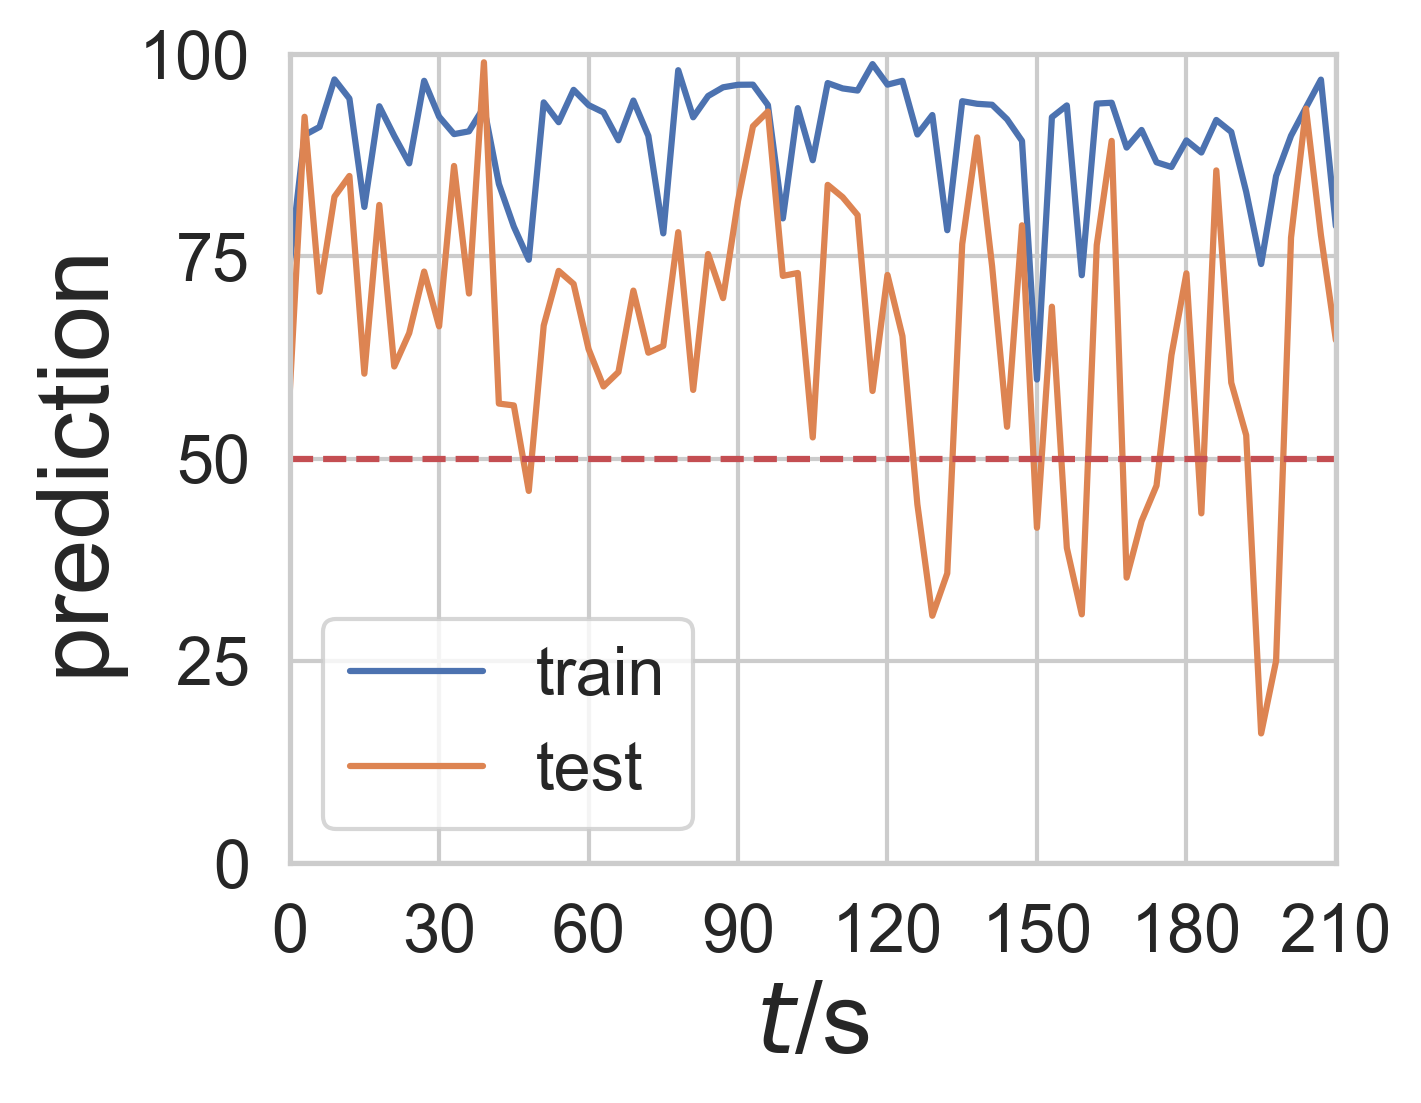

In [23]:
fontsize=16
plt.figure(figsize=(4.5, 3.5), dpi=300)
plt.plot(np.arange(71), train_matchable.reshape([-1, 71]).permute(1, 0).mean(-1))
plt.plot(np.arange(71), test_matchable.reshape([-1, 71]).permute(1, 0).mean(-1))
plt.hlines(0.5, 0, 71, color='r', linestyles='--')
plt.xlim([0, 70])
seg_list = np.arange(0, 71, 10)
sec_list = [str(i) for i in np.arange(0, 71, 10) * 3]
plt.xticks(seg_list, sec_list, fontsize=fontsize)

seg_list = np.linspace(0, 1, 5)
sec_list = seg_list*100
sec_list=sec_list.astype(np.int32)
plt.yticks(seg_list, sec_list, fontsize=fontsize)
plt.ylim([0, 1])

plt.legend(['train', 'test'], fontsize=fontsize,loc='lower left')
plt.xlabel('$t$/s', fontsize=fontsize*1.5)
plt.ylabel('prediction', fontsize=fontsize*1.5)
train_acc = np.round((sum(train_matchable > 0.5) / len(train_matchable)).item() * 100, 2)
test_acc = np.round((sum(test_matchable > 0.5) / len(test_matchable)).item() * 100, 2)
print(f'train acc:{train_acc}%\n test acc:{test_acc}%')
# plt.text(19, 0.1, f'train acc:{train_acc}%\n test acc:{test_acc}%', fontsize=fontsize, color='black')
plt.savefig('paper/train_test_feature_OneWayDilationVideoGRUModel_exp1_eeg_video_match_prediction_mean.pdf', bbox_inches='tight')
plt.show()

In [24]:
# print(sum(train_matchable > 0.5) / len(train_matchable))
# print(sum(test_matchable > 0.5) / len(test_matchable))

# video dino TSNE plot
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax
import matplotlib.ticker as ticker
scaler = StandardScaler()
X = moviefeat_dict[0]
X = scaler.fit_transform(X)
pca = TSNE(n_components=2)
X_pca = pca.fit_transform(X)

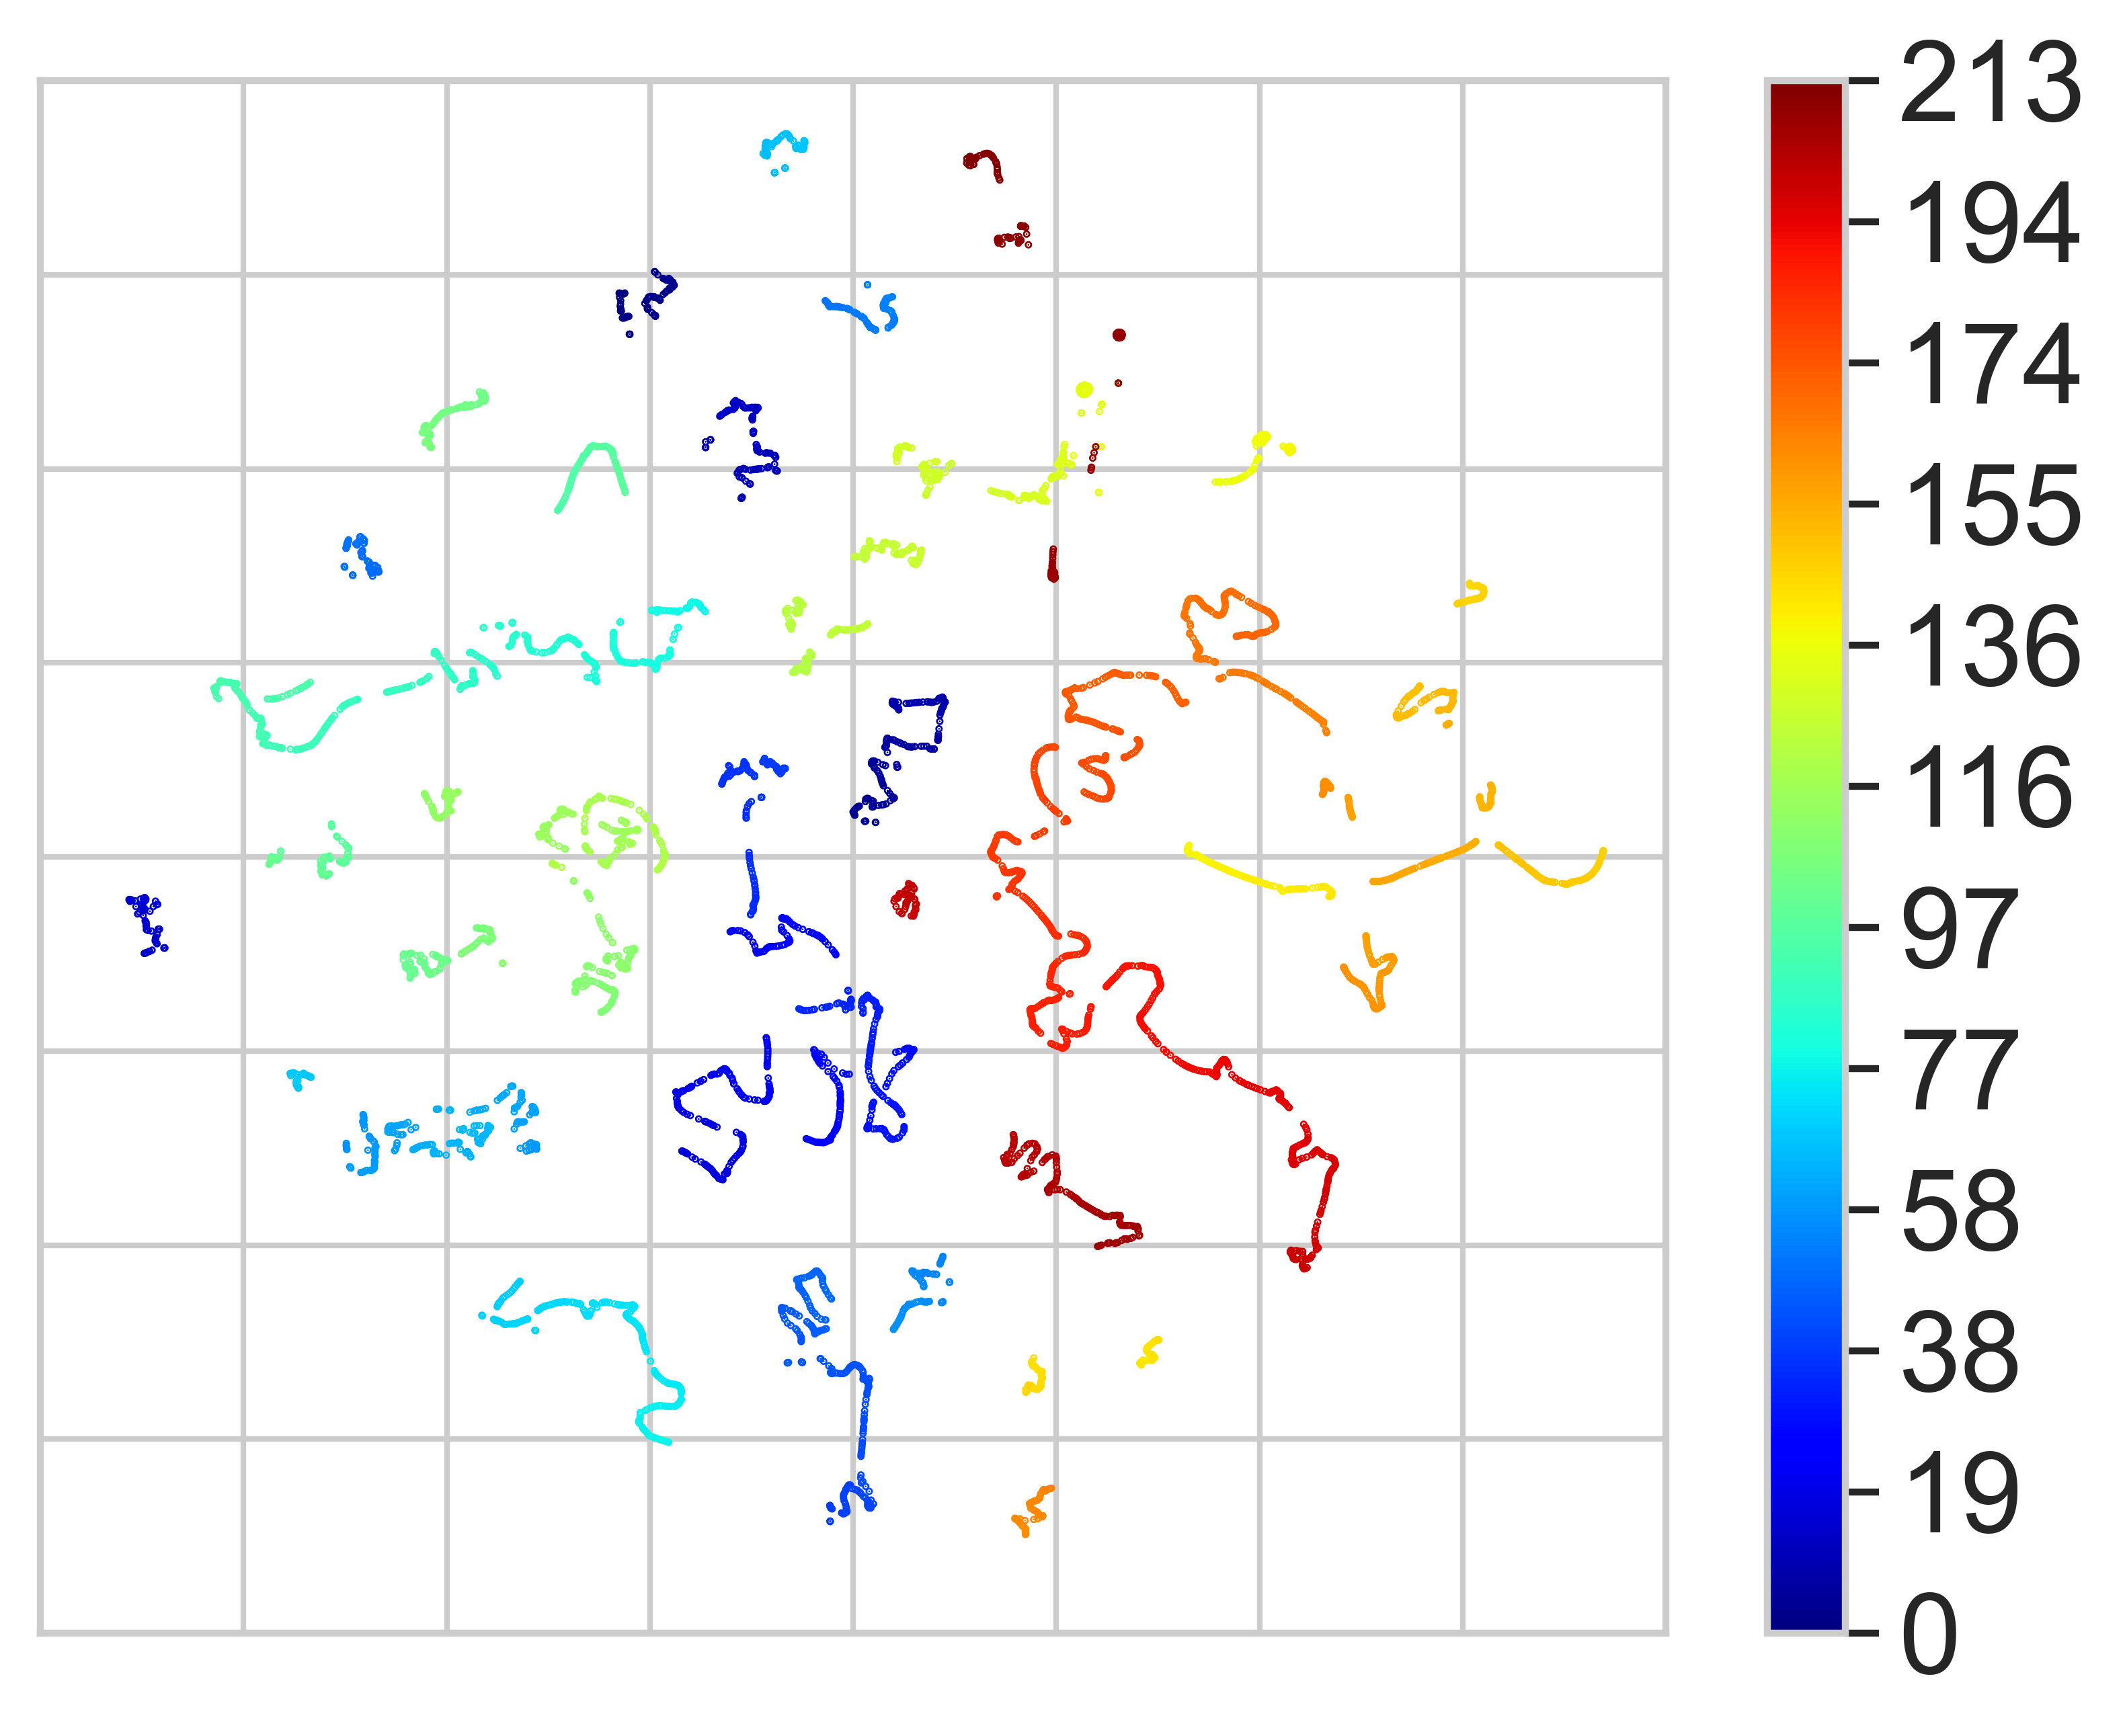

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6.5,5), dpi=600)
# plt.figure(figsize=(5, 5), dpi=300)
im=ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(X.shape[0]), cmap='jet', s=0.1)
ax.set_xticklabels([])
ax.set_yticklabels([])
# cax = add_right_cax(ax, pad=0.02, width=0.2)
cb1 = fig.colorbar(im)
# tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
# cb1.locator = tick_locator
t_tick=np.linspace(0,X.shape[0],12)
# print(t_tick.shape)

cb1.set_ticks(t_tick)
cb1.set_ticklabels((t_tick/25).astype(np.int32),fontsize=20)
# cb1.update_ticks()
plt.xlim([-100,100])
plt.ylim([-100,100])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
plt.savefig(mkdir('paper/dino_feature.pdf'), bbox_inches='tight')
plt.show()

In [318]:
def get_traditional_features_from_dataset(eeg_dataset):
    extractor = FeatureExtractor()
    feat_all = []
    person_all = []
    for idx, item in enumerate(eeg_dataset):
        eeg = item['eeg']
        eeg_feat = extractor.extract(eeg.detach().cpu().numpy())
        feat_all.append(eeg_feat)
    feat_all_tensor = np.stack(feat_all, axis=0)
    return feat_all_tensor

train_eeg_tradition_feature_list=get_traditional_features_from_dataset(train_eeg_data1)
test_eeg_tradition_feature_list=get_traditional_features_from_dataset(test_eeg_data1)

In [28]:
# silhouette score table
ss_table = np.zeros([4, 2])
extractor = FeatureExtractor()
feat_all = []
person_all = []
for idx, item in enumerate(test_eeg_data1):
    eeg = item['eeg']
    pid = item['person_nnid']
    eeg_feat = extractor.extract(eeg.detach().cpu().numpy())
    feat_all.append(eeg_feat)
    person_all.append(pid)
feat_all_tensor = np.stack(feat_all, axis=0)

# segment level person traditional features
test_person_labels = np.repeat(np.arange(6), 71)
test_eeg_feature_cluster = feat_all_tensor.copy()
ss_table[0, 0] = silhouette_score(test_eeg_feature_cluster, test_person_labels, metric='cosine')

# segment level position traditional features
test_seg_labels = np.tile(np.arange(71), 6)
test_eeg_feature_cluster = feat_all_tensor.copy()
ss_table[0, 1] = silhouette_score(test_eeg_feature_cluster, test_seg_labels, metric='cosine')

# segment level person deep features
test_person_labels = np.repeat(np.arange(6), 71)
test_eeg_feature_cluster = test_eeg_feature_list.reshape([-1, 256 * 75])
ss_table[1, 0] = silhouette_score(test_eeg_feature_cluster, test_person_labels, metric='cosine')

# segment level position deep features
test_seg_labels = np.tile(np.arange(71), 6)
test_eeg_feature_cluster = test_eeg_feature_list.reshape([-1, 256 * 75])
ss_table[1, 1] = silhouette_score(test_eeg_feature_cluster, test_seg_labels, metric='cosine')

# frame level postion deep features
test_postion_labels = np.tile(np.repeat(np.arange(71), 75), 6)
test_eeg_feature_cluster = torch.permute(test_eeg_feature_list, (0, 2, 1)).contiguous().reshape([-1, 256])
ss_table[2, 0] = silhouette_score(test_eeg_feature_cluster, test_postion_labels, metric='cosine')

# frame level person deep features
test_person_labels = np.repeat(np.arange(6), 71 * 75)
test_eeg_feature_cluster = torch.permute(test_eeg_feature_list, (0, 2, 1)).contiguous().reshape([-1, 256])
ss_table[2, 1] = silhouette_score(test_eeg_feature_cluster, test_person_labels, metric='cosine')

# frame level position DINO features
unit = 75
max_label_num = int(moviefeat_dict[0].shape[0] / unit)
test_eeg_feature_cluster = moviefeat_dict[0][:unit * max_label_num]
test_seg_labels = np.tile(np.arange(unit), max_label_num)
ss_table[3, 1] = silhouette_score(test_eeg_feature_cluster, test_seg_labels, metric='cosine')
print('silhouette score table')
print(ss_table)

silhouette score table
[[ 0.13609938 -0.3495124 ]
 [-0.00405103 -0.04892163]
 [-0.03662074 -0.00917919]
 [ 0.         -0.02748434]]


In [161]:
print(np.round(ss_table,3))

[[ 0.136 -0.35 ]
 [-0.004 -0.049]
 [-0.037 -0.009]
 [ 0.    -0.027]]


In [47]:
def plot_silhouette_score(test_eeg_feature_cluster, test_person_labels, plt_name,ext_name='.pdf'):
    X = TSNE(n_components=2).fit_transform(test_eeg_feature_cluster)
    sample_silhouette_values = silhouette_samples(test_eeg_feature_cluster, test_person_labels, metric='cosine')

    import matplotlib.cm as cm
    fig, ax1 = plt.subplots(1,1)
    scale=3
    fontsize=18
    fig.set_size_inches(1*scale, 1*scale)
    fig.set_dpi(300)
    y_lower = 10
    n_clusters = len(np.unique(test_person_labels))
    cluster_labels = test_person_labels
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # ax1.set_title("The silhouette plot",fontsize=fontsize)
    # ax1.set_xlabel("The silhouette coefficient values",fontsize=fontsize)
    # ax1.set_ylabel("Cluster label",fontsize=fontsize)

    # The vertical line for average silhouette score of all the values

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    # ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_xlim([-0.5, 0.7])

    plt.savefig(mkdir(plt_name+'_1'+ext_name), bbox_inches='tight')
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(1.5*scale, 1.5*scale)
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    cax = ax1.scatter(
        X[:, 0], X[:, 1], marker=".", s=40, lw=0, alpha=1, c=colors, edgecolor="k"
    )
    # ax2.set_title("The TSNE plot",fontsize=fontsize)
    plt.savefig(mkdir(plt_name+'_2'+ext_name), bbox_inches='tight')
    # plt.show()

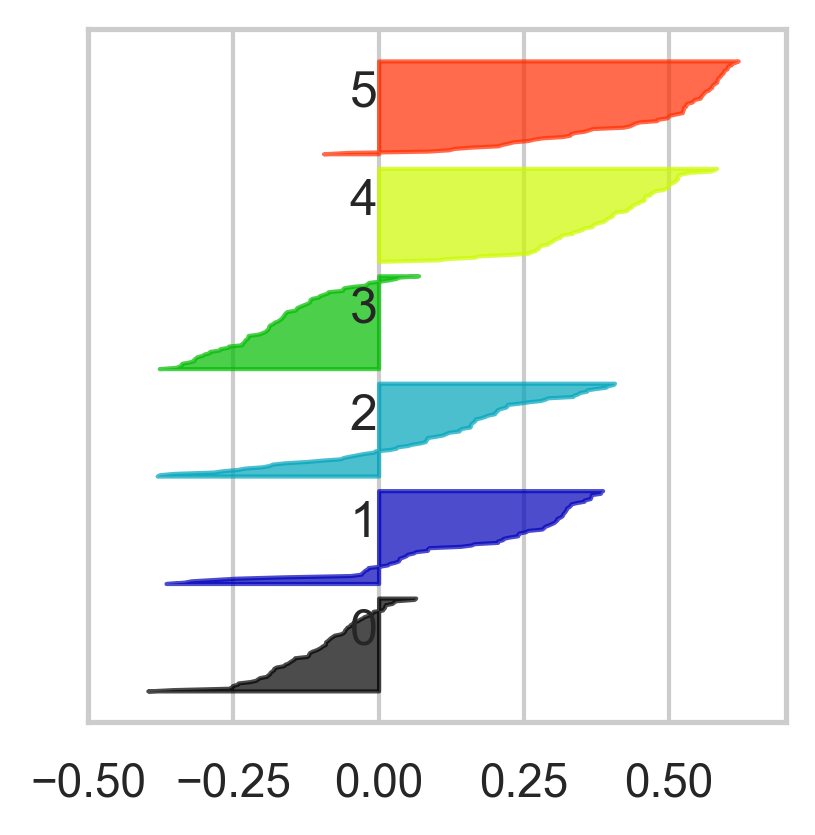

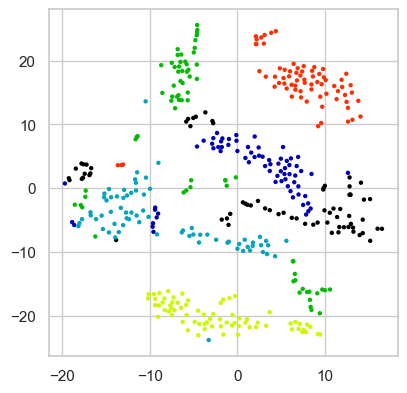

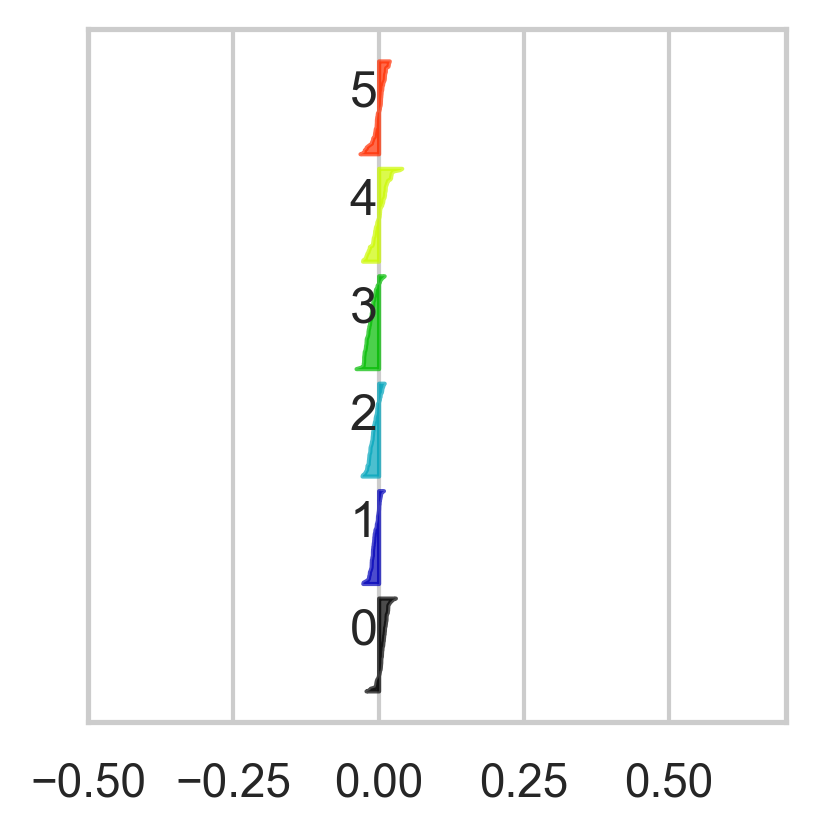

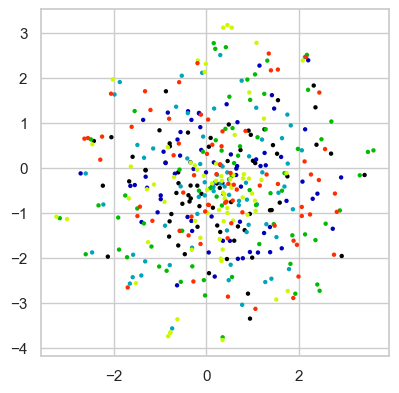

In [48]:
# silhouette plots
# traditional
test_person_labels = np.repeat(np.arange(6), 71)
test_eeg_feature_cluster = feat_all_tensor.copy()
plot_silhouette_score(test_eeg_feature_cluster, test_person_labels, 'paper/traditional_person_feature_cluster')

# ours
test_person_labels = np.repeat(np.arange(6), 71)
test_eeg_feature_cluster = test_eeg_feature_list.reshape([-1, 256 * 75])
plot_silhouette_score(test_eeg_feature_cluster, test_person_labels, 'paper/our_person_feature_cluster')